# Regularized Linear Regression and Bias vs. Variance

To implement regularized linear regression and use it to study models with different bias-variance properties.
## 1 Regularized Linear Regression
To predict the amount of water flowing out of a dam using the change of water level in a reservoir.

In [1]:
import numpy as np
from scipy.optimize import fmin_cg
import scipy.io
import matplotlib.pyplot as plt

In [2]:
# Load training, cross validation, test data set
mat =  scipy.io.loadmat('datasets/ex5data1.mat')

X, y = mat['X'], mat['y']
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))
X_val, y_val = mat['Xval'], mat['yval']
print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))
X_test, y_test = mat['Xtest'], mat['ytest']
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

m = X.shape[0]
X_train = np.insert(X, 0, 1, 1)
y_train = y

X shape: (12, 1)
y shape: (12, 1)
X_val shape: (21, 1)
y_val shape: (21, 1)
X_test shape: (21, 1)
y_test shape: (21, 1)


### Visualizing the dataset

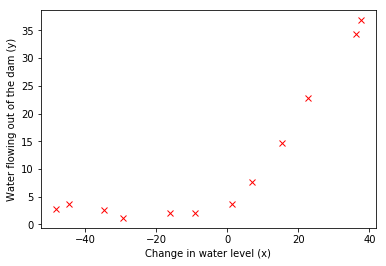

In [3]:
plt.plot(X, y, 'rx')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)');

### Regularized linear regression cost function
$$J(\theta) = \frac{1}{2m}(\sum_{i=1}^{m}\Big(h_\theta(x^{(i)}) - y^{(i)})^2\Big) + \frac{\lambda}{2m}\Big(\sum_{j=1}^{n}\theta_j^2\Big)$$
### Regularized linear regression gradient
for j = 0
$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}$$ 
for j >= 1
$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m}\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\theta_j$$    

In [4]:
# Compute regularized linear regression cost 
def linearRegCostFunction(theta, X, y, lambd):
    m = len(y)
    theta = theta.reshape(-1,1)
    
    h = X @ theta
    err = h - y
    J = (err.T @ err) / (2*m)

    theta_reg = theta[1:]
    cost_reg = lambd/(2*m) * (theta_reg.T @ theta_reg)

    J = J + cost_reg
    return np.asscalar(J)

# Compute regularized linear regression gradients
def linearRegGradientFunction(theta, X, y, lambd):
    m = len(y)
    theta = theta.reshape(-1,1)
    grad = np.zeros(theta.shape)
    
    h = X @ theta
    err = h - y
    theta_reg = theta[1:]
    
    grad[0] = 1/m * np.sum(err)
    grad[1:] = 1/m * (X[:,1:].T @ err) + (lambd/m * theta_reg)
    
    return grad.flatten()

OPTIMIZE_DISPLAY = True
# Train and get optimal Theta
def trainLinearReg(X, y, lambd):
    initial_theta = np.zeros(X.shape[1])
    
    result = fmin_cg(f = linearRegCostFunction,
                         x0 = initial_theta,
                         args = (X, y, lambd),
                         fprime = linearRegGradientFunction,
                         maxiter=200, disp=OPTIMIZE_DISPLAY)
    return result

In [5]:
theta = np.array([1, 1])


cost = linearRegCostFunction(theta, X_train, y_train, 1)
print('Cost at theta = [1, 1]: {}'.format(cost))
print('Expected cost: 303.993192')

Cost at theta = [1, 1]: 303.9931922202643
Expected cost: 303.993192


In [6]:
grad = linearRegGradientFunction(theta, X_train, y_train, 1)
print('Gradient at theta = [1, 1]: {}'.format(grad.flatten()))
print('Expected gradients: [-15.303016 598.250744]')

Gradient at theta = [1, 1]: [-15.30301567 598.25074417]
Expected gradients: [-15.303016 598.250744]


### Fitting linear regression

In [8]:
lambd = 0
theta = trainLinearReg(X_train, y_train, lambd)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5


### Predict on the training set

In [9]:
y_pred = X_train @ theta.reshape(-1,1)
y_pred

array([[ 7.22669488],
       [ 2.36604327],
       [26.39766783],
       [26.87675129],
       [-4.58713577],
       [ 9.799421  ],
       [18.71779179],
       [ 0.3236598 ],
       [13.59880563],
       [-3.2355215 ],
       [15.6673239 ],
       [21.45956978]])

### Plot the best fit line
The fit line tells us that the model is not a good fit to the data because the data has a non-linear pattern. 

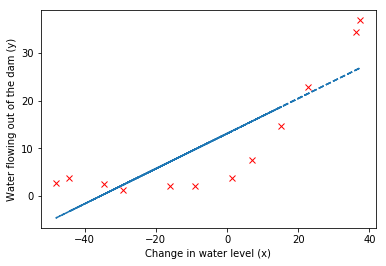

In [10]:
plt.plot(X, y, 'rx')
plt.plot(X, y_pred, '--')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)');

## 2 Bias-Variance
An important concept in machine learning is the bias-variance tradeoff. Models with high **bias** are not complex enough for the data and tend to underfit, while models with high **variance** overfit to the training data.

### Learning curves
A learning curve plots training and cross validation error as a function of training set size (m).
$$J_{train}(\theta) = \frac{1}{2m}\Big[\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})^2\Big]$$
**Training error does not include the regularization term.** Computing the training set error on the incremental size of training subset. However, for the cross validation error, it must be computed on the **entire** cross validation set.

In [11]:
def learningCurve(X, y, X_val, y_val, lambd):
    m = X.shape[0]
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    
    for i in np.arange(1, m+1):
        X_sub = X[:i,:]
        y_sub = y[:i,:]
        theta = trainLinearReg(X_sub, y_sub, lambd)
        error_train[i-1] = linearRegCostFunction(theta, X_sub, y_sub, 0)
        error_val[i-1] = linearRegCostFunction(theta, X_val, y_val, 0)
        
    return error_train, error_val

In [12]:
# Turn optimization output off
OPTIMIZE_DISPLAY = False

lambd = 0
    
error_train, error_val = learningCurve(X_train, y, np.insert(X_val, 0, 1, 1), y_val, lambd)

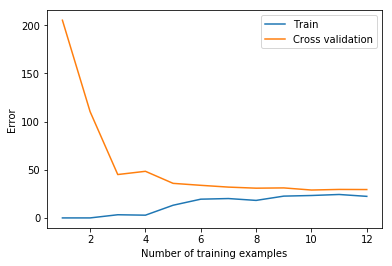

In [13]:
plt.plot(np.arange(1, m+1), error_train, label='Train')
plt.plot(np.arange(1, m+1), error_val, label='Cross validation')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend();

You can observe that both the train error and cross validation error are high when the number of training examples is increased. This reflects a **high bias** problem in the model - the linear regression model is too simple and is unable to fit our dataset well.

## 3 Polynomial regression
For use polynomail regression ,our hypothesis has the form: <br>
$h_\theta(x) = \theta_0 + \theta_1 * (waterLevel) + \theta_2 * (waterLevel)^2 + ... + \theta_p * (waterLevel)^p$

It's a linear regression model where the features are the various powers of the original value.

In [14]:
def polyFeatures(X, p):
    X_poly = np.zeros((X.size, p))

    for i in np.arange(p):
        X_poly[:,i] = X[:,0]**(i+1)

    return X_poly

def featureNormalize(X, mu=None, sigma=None):
    mu = np.mean(X, axis=0) if mu is None else mu
    sigma = np.std(X, axis=0, ddof=1) if sigma is None else sigma
    
    n = X.shape[1]
    X_norm = np.zeros(X.shape)
    
    for i in range(n):
        X_norm[:,i] = (X[:,i] - mu[i]) / sigma[i]
        
    return X_norm, mu, sigma
    

In [15]:
p = 8

# Map X onton Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)
X_poly = np.insert(X_poly, 0, 1, 1)

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(X_test, p)
X_poly_test, _, _ = featureNormalize(X_poly_test, mu, sigma)
X_poly_test = np.insert(X_poly_test, 0, 1, 1)

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(X_val, p)
X_poly_val, _, _ = featureNormalize(X_poly_val, mu, sigma)
X_poly_val = np.insert(X_poly_val, 0, 1, 1)


In [16]:
print('Normalized Training Example 1:\n{}'.format(X_poly[0,:]))

Normalized Training Example 1:
[ 1.         -0.36214078 -0.75508669  0.18222588 -0.70618991  0.30661792
 -0.59087767  0.3445158  -0.50848117]


### Learning Polynomial Regression

In [17]:
OPTIMIZE_DISPLAY = True
lambd = 0
theta = trainLinearReg(X_poly, y, lambd)

         Current function value: 0.046265
         Iterations: 200
         Function evaluations: 376
         Gradient evaluations: 376


In [18]:
theta.reshape(-1,1)

array([[ 11.2167268 ],
       [ 10.56831301],
       [ 20.34884348],
       [ 18.60485801],
       [-38.0924765 ],
       [-42.229881  ],
       [ 35.33405239],
       [ 31.74080679],
       [ -5.12854428]])

While the cost from Octave exercise gives the cost of 0.1426381 and thetas:
```
 11.2159
 11.3488
 14.7768
 11.3209
-12.5035
-15.2529
  7.5703
  3.9376
 -4.7987
```
After trying to find what causes the difference, it could be in the implementation of the minize function. I'll stick with this Theta, this will cause the later plots different as well.

In [19]:
def plotFit(min_x, max_x, mu, sigma, theta, p):
    x = np.arange(min_x-10,max_x+15,0.05)
    x_fit = x.reshape(-1,1)
    
    x_fit = polyFeatures(x_fit, p)
    x_fit, _, _ = featureNormalize(x_fit, mu, sigma)
    x_fit = np.insert(x_fit, 0, 1, 1)
    
    y_fit = x_fit @ theta.reshape(-1,1)
    plt.plot(x, y_fit, '--')
    
def plotData(X, y):
    plt.plot(X, y, 'rx')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    
    
def plotLearningCurve(m, error_train, error_val):
    plt.plot(np.arange(1, m+1), error_train, label='Train')
    plt.plot(np.arange(1, m+1), error_val, label='Cross validation')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.legend();

### Polynomial Regression with no regularization
##### Polynomial fit, $\lambda = 0$

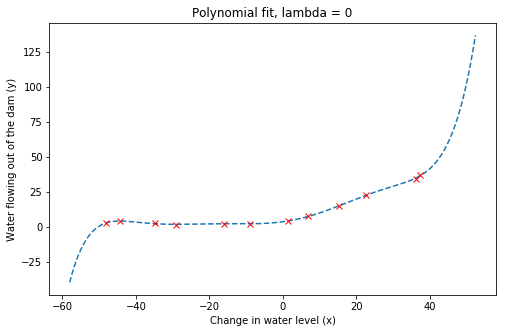

In [20]:
min_x = min(X)
max_x = max(X)
plt.figure(figsize=(8,5))
# Plot fit line
plotFit(min_x, max_x, mu, sigma, theta, p)
# Plot training data points
plotData(X, y)
plt.title('Polynomial fit, lambda = {}'.format(lambd));

##### Learning Curve, $\lambda = 0$

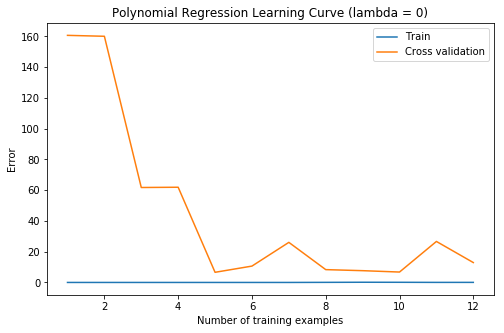

In [21]:
# Turn optimization output off
OPTIMIZE_DISPLAY = False

error_train, error_val = learningCurve(X_poly, y, X_poly_val, y_val, lambd)
plt.figure(figsize=(8,5))
plotLearningCurve(m, error_train, error_val)
plt.title('Polynomial Regression Learning Curve (lambda = {})'.format(lambd));

### Regularized Polynomial Regression, $\lambda = 1$

For $\lambda = 1$, you should see a polynomial fit that follows the data trend well and a learning curve showing that both the cross validation and training error converge to a relatively low value. This shows the $\lambda = 1$ regularized polynomial regression model does not have the high-bias or high-variance problems. In effect, it achieves a good trade-off between bias and variance.

##### Polynomial fit, $\lambda = 1$

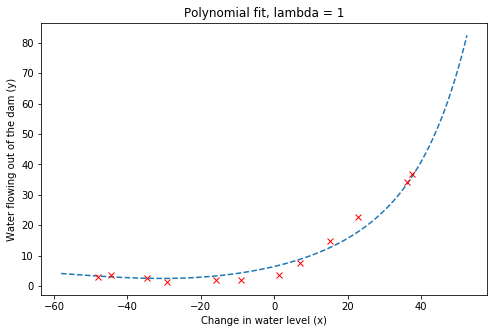

In [22]:
lambd = 1
theta = trainLinearReg(X_poly, y, lambd)

plt.figure(figsize=(8,5))
# Plot fit line
plotFit(min_x, max_x, mu, sigma, theta, p)
# Plot training data points
plotData(X, y)
plt.title('Polynomial fit, lambda = {}'.format(lambd));

##### Learning Curve, $\lambda = 1$

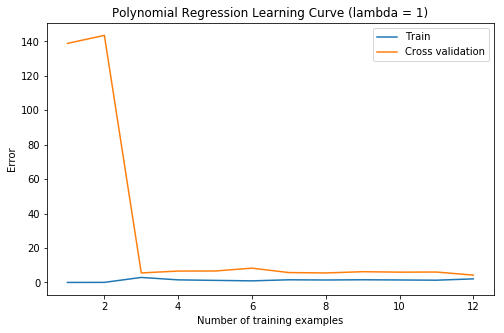

In [23]:
error_train, error_val = learningCurve(X_poly, y, X_poly_val, y_val, lambd)

plt.figure(figsize=(8,5))
plotLearningCurve(m, error_train, error_val)
plt.title('Polynomial Regression Learning Curve (lambda = {})'.format(lambd));

### Regularized Polynomial Regression, $\lambda = 100$

For $\lambda = 100$, you should see a polynomial fit that does not follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.

##### Polynomial fit, $\lambda = 100$

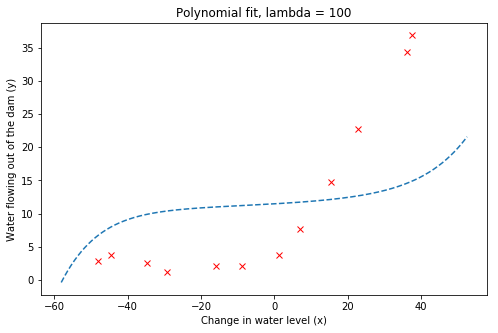

In [24]:
lambd = 100
theta = trainLinearReg(X_poly, y, lambd)

plt.figure(figsize=(8,5))
# Plot fit line
plotFit(min_x, max_x, mu, sigma, theta, p)
# Plot training data points
plotData(X, y)
plt.title('Polynomial fit, lambda = {}'.format(lambd));

##### Learning Curve, $\lambda = 100$

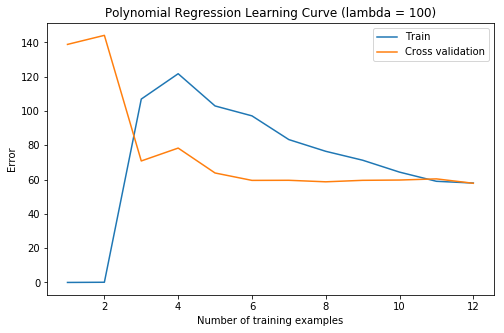

In [25]:
error_train, error_val = learningCurve(X_poly, y, X_poly_val, y_val, lambd)

plt.figure(figsize=(8,5))
plotLearningCurve(m, error_train, error_val)
plt.title('Polynomial Regression Learning Curve (lambda = {})'.format(lambd));

### Selecting $\lambda$ using a cross validation set

In [26]:
lambda_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
error_train = np.zeros(lambda_vec.size)
error_val = np.zeros(lambda_vec.size)

for i,l in enumerate(lambda_vec):
    theta = trainLinearReg(X_poly, y, l)
    error_train[i] = linearRegCostFunction(theta, X_poly, y, 0)
    error_val[i] = linearRegCostFunction(theta, X_poly_val, y_val, 0)

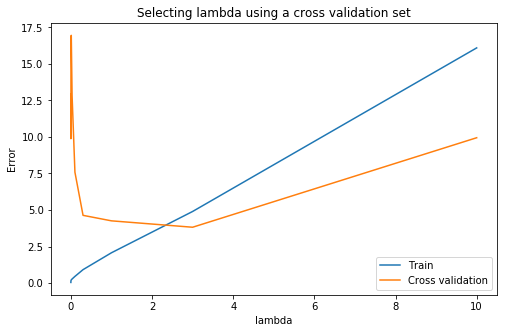

In [27]:
plt.figure(figsize=(8,5))
plt.plot(lambda_vec, error_train, label='Train')
plt.plot(lambda_vec, error_val, label='Cross validation')
plt.xlabel('lambda')
plt.ylabel('Error')
plt.title('Selecting lambda using a cross validation set')
plt.legend();

### Select $\lambda = 3$

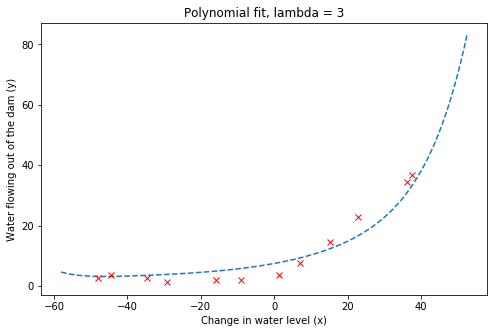

In [28]:
lambd = 3
theta = trainLinearReg(X_poly, y, lambd)

plt.figure(figsize=(8,5))
# Plot fit line
plotFit(min_x, max_x, mu, sigma, theta, p)
# Plot training data points
plotData(X, y)
plt.title('Polynomial fit, lambda = {}'.format(lambd));

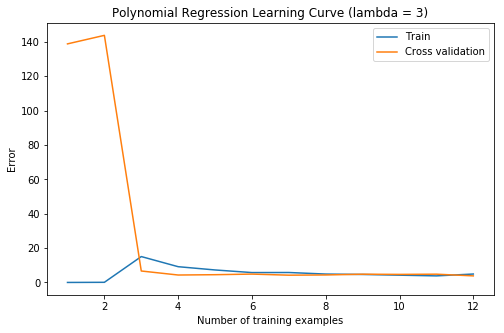

In [29]:
error_train, error_val = learningCurve(X_poly, y, X_poly_val, y_val, lambd)

plt.figure(figsize=(8,5))
plotLearningCurve(m, error_train, error_val)
plt.title('Polynomial Regression Learning Curve (lambda = {})'.format(lambd));